In [317]:
import numpy as np
import random
from dataclasses import dataclass
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn.functional as F

In [318]:
env = gym.make("CartPole-v1")

In [319]:
nS = env.observation_space.low.size
nA = env.action_space.n
nH = 128

In [320]:
gamma = 0.9
alpha = 1e-4
eps = 1.0
eps_decay = 0.999
batch_size = 128

In [321]:
max_episodes = 200
max_steps = 100

In [323]:
qnet = torch.nn.Sequential(
    torch.nn.Linear(nS, nH),
    torch.nn.ReLU(),
    torch.nn.Linear(nH, nH),
    torch.nn.ReLU(),
    torch.nn.Linear(nH, nA)
)

In [324]:
opt = torch.optim.Adam(qnet.parameters(), lr=alpha)

In [325]:
@dataclass
class Transition:
    state: int
    action: int
    next_state: int
    reward: float
    done: bool

class ReplayBuffer(object):
    def __init__(self, size):
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def push(self, *args):
        data = Transition(*args)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def sample_batch(self, batch_size):
        return [self._storage[random.randint(0, len(self._storage) - 1)] for _ in range(batch_size)]

In [322]:
def select_action(net, s, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(nA)
    with torch.no_grad():
        return qnet(torch.tensor([s])).argmax().item()

In [326]:
def train(qnet, buffer, opt):
    sample = buffer.sample_batch(batch_size)
    s = torch.tensor([t.state for t in sample])
    s_prime = torch.tensor([t.next_state for t in sample])
    a = torch.tensor([t.action for t in sample])
    r = torch.tensor([t.reward for t in sample])
    d = 1 - 1*torch.tensor([t.done for t in sample])
        
    q = qnet(s)[np.arange(a.shape[0]), a]
    q_expected = r + gamma * d * qnet(s_prime).max(dim=1).values
    criterion = torch.nn.MSELoss()
    loss = criterion(q, q_expected)
    
    opt.zero_grad()
    loss.backward()
    opt.step()

In [327]:
Rs = []
Eps = []
buffer = ReplayBuffer(10_000)
for episode in range(max_episodes):
    s, _ = env.reset()
    R = 0
    for step in range(max_steps):
        a = select_action(qnet, s, eps)
        s_prime, r, done, _, _ = env.step(a)
        buffer.push(s, a, s_prime, r, done)
        R += r
        
        train(qnet, buffer, opt)

        if done:
            break
            
        s = s_prime
        eps *= eps_decay
    Rs.append(R)
    Eps.append(eps)

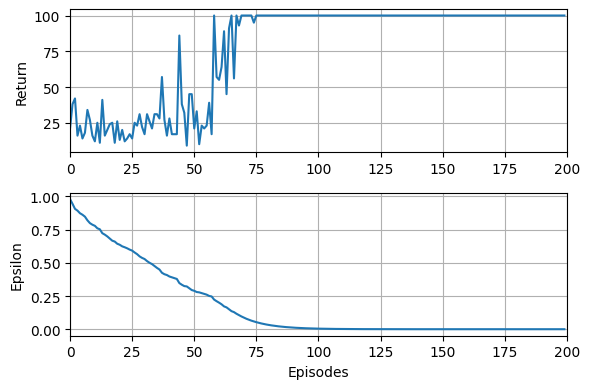

In [328]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4))
axes = axes.flatten()
axes[0].plot(Rs)
axes[0].set_xlim(0, max_episodes)
axes[0].grid()
axes[0].set_ylabel("Return")
axes[1].plot(Eps)
axes[1].set_xlim(0, max_episodes)
axes[1].grid()
axes[1].set_xlabel("Episodes")
axes[1].set_ylabel("Epsilon")
plt.tight_layout()
plt.show()